In [59]:
%matplotlib inline
import random
from skimage import io
import matplotlib.pyplot as plt
from ipywidgets import interact
from keras.models import Model, Sequential 
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD
import numpy as np
from keras.layers import Input, Flatten, Dense, Dropout, Conv2D, MaxPooling2D, Merge
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop
from keras import backend as K
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from keras.layers.core import Lambda
import keras
import os
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import pandas as pd

CSV_DIR = '../data/csv/'
WEIGHTS_DIR = '../weights/'


### Load Data

In [2]:
train_df = pd.read_csv("train_id.csv")
test_df = pd.read_csv("test_id.csv")

In [3]:
X_train_paths = list(train_df.X_train)
X_test_paths = list(test_df.X_test)

In [4]:
X_train = np.array(io.imread_collection(X_train_paths))
X_test = np.array(io.imread_collection(X_test_paths))

In [5]:
X_train.shape, X_test.shape

((200, 230, 105, 3), (200, 230, 105, 3))

In [6]:
y_train = np.array(train_df.y)
y_test = np.array(test_df.y)

In [7]:
y_train.shape, y_test.shape

((200,), (200,))

In [8]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [9]:
y_train.shape, y_test.shape

((200, 10), (200, 10))

### Build Network Architecture

In [34]:
def base_network(input_shape):
    model = Sequential()

    model.add(Conv2D(32, 11, activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(3, 2))

    model.add(Conv2D(64, 9, activation='relu', padding='VALID'))
    model.add(Conv2D(64, 9, activation='relu', padding='VALID'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    
    model.add(Conv2D(128, 7, strides=(2,2), activation='relu', padding='SAME'))
    model.add(Conv2D(128, 5, activation='relu', padding='VALID'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    
    return model

In [35]:
network = base_network([230, 105, 3])

In [36]:
input_layer = Input(shape=[230, 105, 3])

In [37]:
pretrained_network = network(input_layer)

In [38]:
pretrained_model = Model(input_layer, pretrained_network)

In [39]:
pretrained_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 230, 105, 3)       0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 64)                35171392  
Total params: 35,171,392
Trainable params: 35,171,008
Non-trainable params: 384
_________________________________________________________________


In [40]:
pretrained_model.load_weights('weights/exp_5-w.h5')

In [41]:
pretrained_model.layers[1].layers

In [42]:
for layer in pretrained_model.layers[1].layers:
    layer.trainable = False

In [43]:
pretrained_model.layers[1].layers[-1].trainable = True
pretrained_model.layers[1].layers[-2].trainable = True
pretrained_model.layers[1].layers[-3].trainable = False

In [44]:
for layer in network.layers:
    print(layer.trainable, layer)

False <keras.layers.convolutional.Conv2D object at 0x7f3100745908>
False <keras.layers.pooling.MaxPooling2D object at 0x7f310063d6a0>
False <keras.layers.convolutional.Conv2D object at 0x7f310076c898>
False <keras.layers.convolutional.Conv2D object at 0x7f310076c860>
False <keras.layers.core.Dropout object at 0x7f31007455c0>
False <keras.layers.normalization.BatchNormalization object at 0x7f30f18d38d0>
False <keras.layers.convolutional.Conv2D object at 0x7f30f18d9160>
False <keras.layers.convolutional.Conv2D object at 0x7f30f06f4e48>
False <keras.layers.core.Dropout object at 0x7f30f058b9e8>
False <keras.layers.normalization.BatchNormalization object at 0x7f30f066a898>
False <keras.layers.core.Flatten object at 0x7f30f06780b8>
False <keras.layers.core.Dense object at 0x7f30f0662d30>
True <keras.layers.core.Dropout object at 0x7f30f0538d30>
True <keras.layers.core.Dense object at 0x7f30f07131d0>


In [45]:
pretrained_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 230, 105, 3)       0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 64)                35171392  
Total params: 35,171,392
Trainable params: 32,832
Non-trainable params: 35,138,560
_________________________________________________________________


In [46]:
head_layer = Dropout(0.5)(pretrained_model.outputs[0]) 
head_layer = Dense(64, activation='relu')(head_layer) 
head_layer = Dense(10, activation='softmax')(head_layer)
id_model = Model(pretrained_model.inputs, head_layer)

In [47]:
id_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 230, 105, 3)       0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 64)                35171392  
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                650       
Total params: 35,176,202
Trainable params: 37,642
Non-trainable params: 35,138,560
_________________________________________________________________


In [48]:
id_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
tf_board = TensorBoard('logs/id_exp_4')

In [50]:
id_model.fit(X_train, y_train, batch_size=5, epochs=1000, 
             verbose=1, validation_data=(X_test, y_test),
              callbacks=[tf_board])

Train on 200 samples, validate on 200 samples
Epoch 1/1000
200/200 [==============================] - 1s 5ms/step - loss: 2.4432 - acc: 0.0550 - val_loss: 2.2931 - val_acc: 0.1450
Epoch 2/1000
200/200 [==============================] - 1s 5ms/step - loss: 2.2892 - acc: 0.1050 - val_loss: 2.2585 - val_acc: 0.1800
Epoch 3/1000
200/200 [==============================] - 1s 5ms/step - loss: 2.2687 - acc: 0.1300 - val_loss: 2.1927 - val_acc: 0.2000
Epoch 4/1000
200/200 [==============================] - 1s 4ms/step - loss: 2.1915 - acc: 0.1300 - val_loss: 2.1320 - val_acc: 0.2050
Epoch 5/1000
200/200 [==============================] - 1s 4ms/step - loss: 2.1711 - acc: 0.1850 - val_loss: 2.0414 - val_acc: 0.1450
Epoch 6/1000
200/200 [==============================] - 1s 6ms/step - loss: 2.0880 - acc: 0.1800 - val_loss: 2.0424 - val_acc: 0.2100
Epoch 7/1000
200/200 [==============================] - 1s 5ms/step - loss: 2.1377 - acc: 0.1950 - val_loss: 2.0113 - val_acc: 0.1950
Epoch 8/1000
200

In [51]:
id_model.save("models/id_exp_4.h5")
id_model.save_weights("weights/id_exp_4-w.h5")

In [52]:
pred = id_model.predict(X_test)

In [56]:
pred_y = np.argmax(pred, axis=1)
pred_y

array([3, 1, 9, 8, 9, 1, 2, 5, 2, 1, 3, 5, 8, 0, 9, 0, 0, 1, 0, 3, 5, 9, 5,
       3, 3, 6, 1, 7, 3, 3, 5, 9, 8, 6, 3, 2, 8, 9, 5, 1, 2, 8, 0, 0, 1, 6,
       8, 8, 8, 3, 9, 6, 3, 6, 1, 5, 6, 2, 8, 3, 2, 3, 7, 9, 5, 8, 3, 5, 8,
       9, 8, 0, 7, 9, 0, 9, 5, 2, 7, 9, 9, 2, 1, 3, 8, 3, 8, 3, 5, 8, 3, 0,
       0, 3, 3, 8, 9, 1, 8, 7, 0, 5, 8, 1, 5, 2, 9, 8, 8, 2, 9, 8, 1, 1, 8,
       5, 5, 5, 3, 0, 8, 5, 0, 0, 8, 3, 7, 3, 5, 3, 5, 5, 9, 0, 8, 3, 9, 1,
       9, 2, 6, 5, 3, 8, 8, 1, 1, 5, 5, 7, 8, 3, 8, 9, 7, 0, 7, 1, 5, 3, 3,
       6, 8, 1, 8, 0, 1, 5, 8, 3, 6, 5, 1, 8, 0, 5, 8, 9, 8, 8, 5, 0, 3, 8,
       5, 3, 3, 5, 5, 1, 6, 8, 0, 1, 3, 5, 9, 1, 8, 5])

In [57]:
true_y = np.argmax(y_test, axis=1)

In [58]:
accuracy_score(true_y, pred_y)

0.61499999999999999

In [62]:
confusion_matrix(true_y, pred_y)

array([[20,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 16,  0,  0,  0,  0,  0,  0,  4,  0],
       [ 0,  0,  0,  0,  0, 20,  0,  0,  0,  0],
       [ 0,  0,  0, 20,  0,  0,  0,  0,  0,  0],
       [ 0,  3,  0, 13,  0,  0,  0,  0,  2,  2],
       [ 0,  0,  0,  0,  0, 12,  0,  0,  8,  0],
       [ 0,  0, 10,  0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  1,  0,  9,  9,  0],
       [ 0,  4,  0,  0,  0,  0,  0,  0, 16,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 20]])

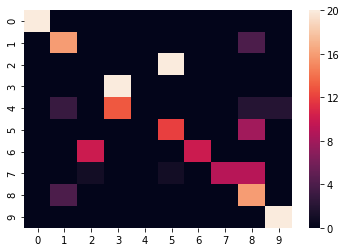

In [61]:
sns.heatmap(confusion_matrix(true_y, pred_y))